## Entrenando modelos de identificación de objetos

### Reconocimiento de formas

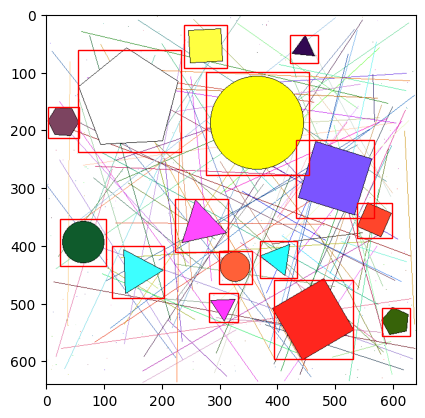

In [1]:
# prompt: Dado el fichero .zip referenciado con la url https://raw.github.com/FranPuentes/iTI2025/main/data/gshapes.zip, 
# descárgalo, ábrelo y escoge aleatoriamente un fichero .png y su pareja .txt que tienen el mismo nombre en el subdirectorio "train". 
# Dibuja la imagen y la misma con las identificaciones (formato yolo) que contiene el fichero .txt.

import zipfile
import random
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Descargar el fichero .zip
#!wget -q https://raw.github.com/FranPuentes/iTI2025/main/data/gshapes.zip --no-clobber -O gshapes.zip

# Abrir el fichero .zip
# with zipfile.ZipFile('gshapes.zip', 'r') as zip_ref:
#  zip_ref.extractall('.')

# Escoger aleatoriamente un fichero .png y su pareja .txt
train_dir = 'gshapes/train'
png_files = [f for f in os.listdir(train_dir) if f.endswith('.png')]
# Sort the list alphabetically
# png_files = sorted(png_files)
# random_file = png_files[0]
random_file = random.choice(png_files)


txt_file = random_file.replace('.png', '.txt')

# Dibujar la imagen
image_path = os.path.join(train_dir, random_file)
image = plt.imread(image_path)
fig, ax = plt.subplots(1)
ax.imshow(image)

# Dibujar las identificaciones
txt_path = os.path.join(train_dir, txt_file)
with open(txt_path, 'r') as f:
  lines = f.readlines()
for line in lines:
  class_id, x_center, y_center, width, height = map(float, line.strip().split())
  x_min = (x_center - width / 2) * image.shape[1]
  y_min = (y_center - height / 2) * image.shape[0]
  width = width * image.shape[1]
  height = height * image.shape[0]
  rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()


0. círculo
1. triángulo
2. cuadrado
3. pentágono
4. hexágono

In [2]:
# prompt: Instala con pip la librería Ultralytics y entrena un modelo YOLO v8 usando el contenido del .zip indicado. 
# Al finalizar muestra una matriz de confusión con su evaluación. No hagas llamadas a la línea de comandos.

# Instalar Ultralytics (si no está ya instalado)
#!pip -q install ultralytics

import matplotlib.pyplot as plt

# Entrenar el modelo YOLOv8
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # Cargar un modelo pre-entrenado (opcional)
results = model.train(data='./gshapes.zip', epochs=1)  # Ajustar epochs según sea necesario


New https://pypi.org/project/ultralytics/8.3.248 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.206 🚀 Python-3.12.3 torch-2.8.0+cpu CPU (Intel Core i7-8550U 1.80GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./gshapes.zip, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=Fa

KeyboardInterrupt: 

array([[        122,           0,           0,           0,           0,           0],
       [          0,          69,          15,           0,           0,          53],
       [          0,          38,          23,           0,           0,          17],
       [          0,           0,           1,          54,          40,          43],
       [          0,           0,           3,          26,          27,          87],
       [        157,         187,         251,         189,         223,           0]])

/tmp/ipykernel_7274/1059550730.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['0', '1', '2', '3', '4', 'fondo'])
/tmp/ipykernel_7274/1059550730.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['0', '1', '2', '3', '4', 'fondo'])


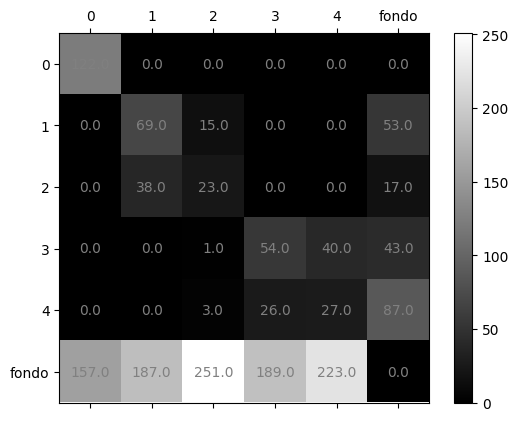

In [ ]:
import numpy as np;

confusion_matrix = results.confusion_matrix.matrix

display(confusion_matrix);

# Crear la figura y el eje
fig, ax = plt.subplots()

# Crear la imagen de la matriz de confusión
cax = ax.matshow(confusion_matrix, cmap=plt.cm.gray)

# Agregar una barra de color
fig.colorbar(cax)

# Establecer las etiquetas de los ejes
ax.set_xticklabels([''] + ['0', '1', '2', '3', '4', 'fondo'])
ax.set_yticklabels([''] + ['0', '1', '2', '3', '4', 'fondo'])

# Mostrar los valores en la matriz
for (i, j), val in np.ndenumerate(confusion_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', color='grey')

# Mostrar la imagen
plt.show()

In [ ]:
# prompt: Genera un interface gradio que usando el modelo entrenado anteriormente, nos permita dibujar una figura y hacer la predicción 
# de que figura es. También debería permitir subir una imagen y aplicarle la predicción del modelo.

!pip -q install gradio
!pip -q install tensorflow

import gradio as gr
import cv2
import numpy as np
from PIL import Image
# import tensorflow as tf

# Función de predicción
def predict_digit(data):
    image = data["composite"].convert('L')
    results = model.predict(image,conf=0.25)
    return results[0].plot(font_size=7)

# Crear la interfaz de Gradio
interface = gr.Interface(
    fn=predict_digit,  # Función que se llama cuando se hace una predicción
    inputs=gr.ImageEditor(image_mode='L', type="pil", canvas_size=(20*20, 20*20), sources=["upload"], layers=False),
    outputs=[gr.Image()],
    live=False
)

# Mostrar la interfaz
interface.launch(debug=True, share=False)

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

/home/roberto/.virtualenvs/transformers/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.



0: 640x640 (no detections), 201.4ms
Speed: 25.7ms preprocess, 201.4ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)
